In [1]:
# Import necessary modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set matplotlib styles
%matplotlib inline
plt.style.use('fivethirtyeight')

# Set dataframe viewing options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
# Upload cleanded data from local machine
file_path = '/Users/nickburkhalter/Desktop/mortality/'
data = '2015_data_cleaned.csv'

df = pd.read_csv(file_path + data)

In [3]:
# Create function to wrangle new features
def wrangle(X):
    
    # Make copy of X so as not to contaminate original
    X = X.copy()
    
    # Create heart_disease feature (did person die of heart disease?)
    X['heart_disease'] = (X['39_cause_recode'].str.contains('heart')) | (X['39_cause_recode'].str.contains('heart'))
    # Create feature for cancer (keyword 'malignant neoplasm')
    X['cancer'] = ((X['39_cause_recode'].str.contains('Malignant neoplasm')) | 
                   (X['39_cause_recode'].str.contains('malignant neoplasm')) | 
                   (X['39_cause_recode'].str.contains('Leukemia')))
    # Create feature for HIV
    X['hiv'] = (X['39_cause_recode'].str.contains('HIV'))
    # Create feature for suicide
    X['suicide'] = (X['39_cause_recode'].str.contains('suicide'))
    # Create feaure for homicide
    X['homicide'] = (X['39_cause_recode'].str.contains('homicide'))
    # Create feature for accidents
    X['accident'] = (X['39_cause_recode'].str.contains('accident'))
    # Create feature for Alzheimer's
    X['alzheimers'] = (X['39_cause_recode'].str.contains("Alzheimer's"))
    # Create feature for respiratory
    X['respiratory'] = ((X['39_cause_recode'].str.contains('respiratory')) | 
                       (X['39_cause_recode'].str.contains('Respiratory')))
    # Create feature for diabetes
    X['diabetes'] = (X['39_cause_recode'].str.contains('Diabetes'))
    
    # Replace 999 value for age with np.nan
    X['detail_age'] = X['detail_age'].replace(999, np.nan)
    # Fill na with mean age
    X['detail_age'] = X['detail_age'].fillna(round(X['detail_age'].mean()))
    
    # Convert our engineered features to int
    eng_feats = ['heart_disease', 'cancer', 'hiv', 'suicide', 'homicide', 
                 'accident', 'alzheimers', 'respiratory', 'diabetes']
    X[eng_feats] = X[eng_feats].astype(int)
    
    # Fill education_level NaNs with Unknown label
    X['education_level'] = X['education_level'].fillna('Unknown')
    
    # Fill activity_code NaNs with Not applicable
    X['activity_code'] = X['activity_code'].fillna('Not applicable')
    
    # Drop columns with supermajority NaNs, duplicates, and others that had < 0
    # permutation importance scores from earlier trials
    X = X.drop(columns=['place_of_injury_for_causes_w00_y34_except_y06_and_y07_', 
                        '130_infant_cause_recode', 'race_recode_3', 
                        'race_recode_5', 'age_bin', 'hispanic_originrace_recode', 
                        'day_of_week_of_death', 'detail_age_type', 'infant_age_recode_22'])
  
    # Drop 39_cause_recode column to avoid leakage
    X = X.drop(columns='39_cause_recode')
    
    return X

In [4]:
# Create wrangled dataframe
test = wrangle(df)

test.shape

(700000, 23)

In [5]:
# We will randomly split the data w/ train_test_split
# We will also include a validation set for our baseline model for quick performance

# Import the proper sklearn module 
from sklearn.model_selection import train_test_split

# Split into train & test sets first
# Seed for reproduceability
X_train, X_test = train_test_split(test, train_size=0.8, test_size=0.2, 
                                  stratify=df['sex'], random_state=42)

# Split X_train into train and val sets
# Seed for reproduceability
X_train, X_val = train_test_split(X_train, train_size=0.8, test_size=0.2, 
                                 stratify=X_train['sex'], random_state=42)

# Drop target column from train, validation, & test sets and set y target vectors for each
target = 'sex'
y_train = X_train[target]
y_val = X_val[target]
y_test = X_test[target]

X_train = X_train.drop(columns=target)
X_val = X_val.drop(columns=target)
X_test = X_test.drop(columns=target)

# REMEMBER: test set will not be used until the end!

In [6]:
# Get majority baseline
print('Train stratification:\n', y_train.value_counts(normalize=True))

Train stratification:
 Male      0.507449
Female    0.492551
Name: sex, dtype: float64


In [7]:
# Create XGBClassifier
# Seed for reproduceability
# Hyperparameters obtained from previous trials
import category_encoders as ce
import xgboost as xgb
from xgboost import XGBClassifier

encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

model = XGBClassifier(
        boost='gbtree',
        n_estimators=469,
        random_state=42,
        n_jobs=-1,
        learning_rate=0.3,
        max_depth=4
    )

model.fit(X_train_encoded, y_train)

XGBClassifier(base_score=0.5, boost='gbtree', booster='gbtree',
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              gamma=0, learning_rate=0.3, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=469, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [8]:
# Find the permutation importance of each column using the eli5 library
# This will help us decide which features to include/exclude
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    model, scoring='roc_auc', n_iter=2, random_state=42
)

permuter.fit(X_val_encoded, y_val)
feature_names = X_val.columns.tolist()
eli5.show_weights(
    permuter, 
    top=None,  # show the permutation importances for all features
    feature_names=feature_names
)

Weight,Feature
0.1736 ± 0.0005,marital_status
0.0467 ± 0.0001,detail_age
0.0207 ± 0.0008,education_level
0.0059 ± 0.0003,place_of_death_and_decedents_status
0.0054 ± 0.0003,heart_disease
0.0051 ± 0.0002,race
0.0046 ± 0.0001,cancer
0.0044 ± 0.0001,manner_of_death
0.0027 ± 0.0006,suicide
0.0022 ± 0.0004,alzheimers


In [9]:
# Let's get the metrics for our model
from sklearn.metrics import classification_report

# Get predictions for our validation set
y_pred  = model.predict(X_val_encoded)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

      Female       0.70      0.63      0.66     55166
        Male       0.67      0.74      0.70     56834

    accuracy                           0.68    112000
   macro avg       0.69      0.68      0.68    112000
weighted avg       0.69      0.68      0.68    112000



In [10]:
# Get ROC AUC score
from sklearn.metrics import roc_auc_score, roc_curve

# Get ROC AUC score for the model
y_pred_proba = model.predict_proba(X_val_encoded)[:,1]
roc_auc_score(y_val, y_pred_proba)  # Should equal ~0.7379 IAW the model we ran earlier

0.7379184456640281

In [11]:
# Define function to plot confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred):
    
    # Get label names from y target vector
    labels = unique_labels(y_true)
    
    # Set column labels for confusion matrix
    columns = [f'Predicted {label}' for label in labels]
    # Set index labels for confusion matrix
    index = [f'Actual {label}' for label in labels]
    
    # Create pandas dataframe to store info prior to plotting
    table = pd.DataFrame(confusion_matrix(y_true, y_pred),
                         columns=columns,
                         index=index)
    
    return sns.heatmap(table, annot=True, fmt='d', cmap='YlGnBu')

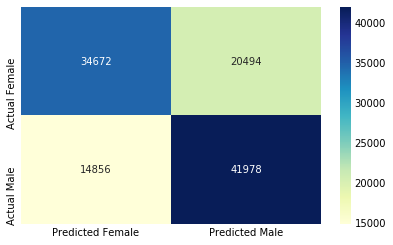

In [12]:
plot_confusion_matrix(y_val, y_pred);

In [13]:
# Visualize the ROC AUC Curve
from ipywidgets import interact, fixed, interactive
from IPython.display import display
from sklearn.metrics import roc_auc_score, roc_curve, classification_report
from sklearn.utils.multiclass import unique_labels

def set_threshold(y_true, y_pred_proba, threshold=0.5):
    """
    For binary classification problems. 
    y_pred_proba : predicted probability of class 1
    """
    
    # Apply threshold to predicted probabilities
    # to get discrete predictions
    class_0, class_1 = unique_labels(y_true)
    y_pred = np.full_like(y_true, fill_value=class_0)
    y_pred[y_pred_proba > threshold] = class_1
    
    # Plot distribution of predicted probabilities
    ax = sns.distplot(y_pred_proba)
    ax.axvline(threshold, color='red')
    plt.title('Distribution of predicted probabilities')
    plt.show()

    # Calculate true positive rate and false positive rate
    true_positives = (y_pred==y_true) & (y_pred==class_1)
    false_positives = (y_pred!=y_true) & (y_pred==class_1)
    actual_positives = (y_true==class_1)
    actual_negatives = (y_true==class_0)
    true_positive_rate = true_positives.sum() / actual_positives.sum()
    false_positive_rate = false_positives.sum() / actual_negatives.sum()
    print('False Positive Rate', false_positive_rate)
    print('True Positive Rate', true_positive_rate)
    
    # Plot ROC curve
    fpr, tpr, thresholds = roc_curve(y_true==class_1, y_pred_proba)
    plt.plot(fpr, tpr)
    plt.title('ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    # Plot point on ROC curve for the current threshold
    plt.scatter(false_positive_rate, true_positive_rate)
    plt.show()
    
    # Show ROC AUC score
    print('Area under the Receiver Operating Characteristic curve:', 
          roc_auc_score(y_true, y_pred_proba))
    
    # Show confusion matrix & classification report
    plot_confusion_matrix(y_true, y_pred)
    print(classification_report(y_true, y_pred))

widget = interactive(set_threshold, 
         y_true=fixed(y_val), 
         y_pred_proba=fixed(y_pred_proba), 
         threshold=(0.0,1.0,0.05))

display(widget)

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.05), Output()), _dom_cla…

In [14]:
# Define function that pulls encoder mappings for the feature we specify
def feature_mapping(feature):
    for item in encoder.mapping:
        if item['col'] == feature:
            feature_mapping = item['mapping']
            
    feature_map = feature_mapping[feature_mapping.index.dropna()]
    category_names = feature_mapping.index.tolist()
    category_codes = feature_mapping.values.tolist()
    
    return (feature_map, category_names, category_codes)

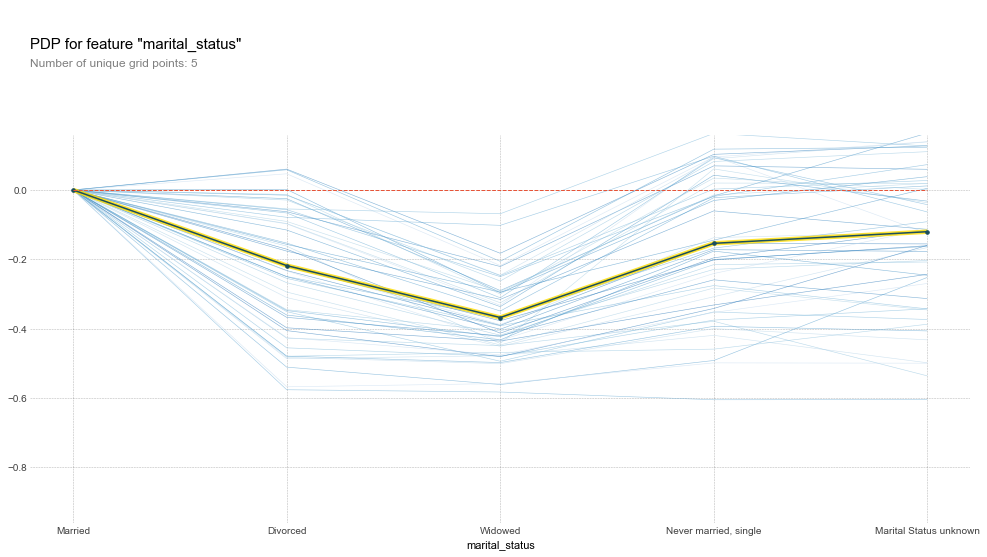

In [15]:
# Let's look at how marital_status affects the model
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'marital_status'

feat_map, names, codes = feature_mapping(feature)

isolated = pdp_isolate(
    model=model, 
    dataset=X_val_encoded, 
    model_features=X_val_encoded.columns, 
    feature=feature
)

pdp_plot(isolated, feature_name=feature, plot_lines=True, frac_to_plot=50);
# Change the xticks labels
plt.xticks([1, 2, 3, 4, 5], names);

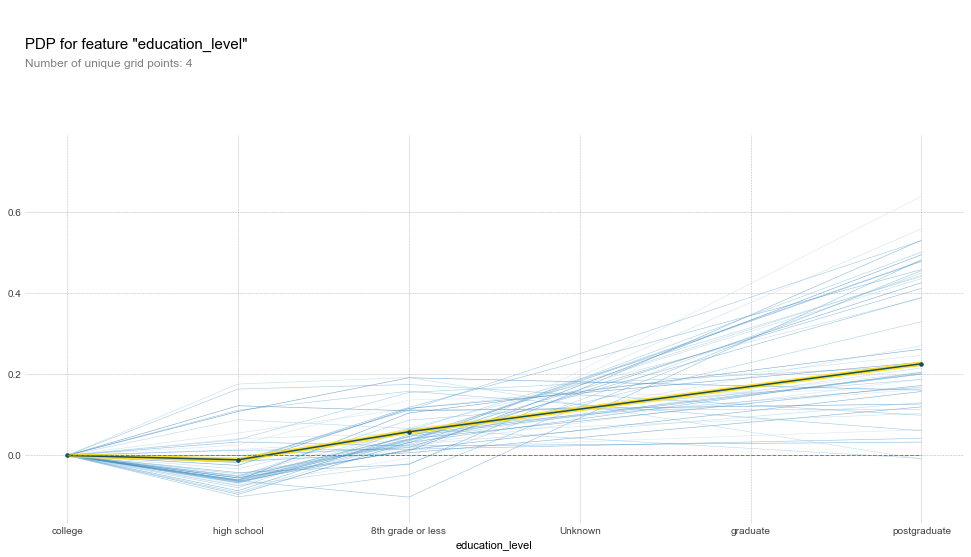

In [16]:
# Let's look at how education_level affects the model
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'education_level'

feat_map, names, codes = feature_mapping(feature)

isolated = pdp_isolate(
    model=model, 
    dataset=X_val_encoded, 
    model_features=X_val_encoded.columns, 
    feature=feature
)

pdp_plot(isolated, feature_name=feature, plot_lines=True, frac_to_plot=50);
# Change the xticks labels
plt.xticks([1,2,3,4,5,6], names);

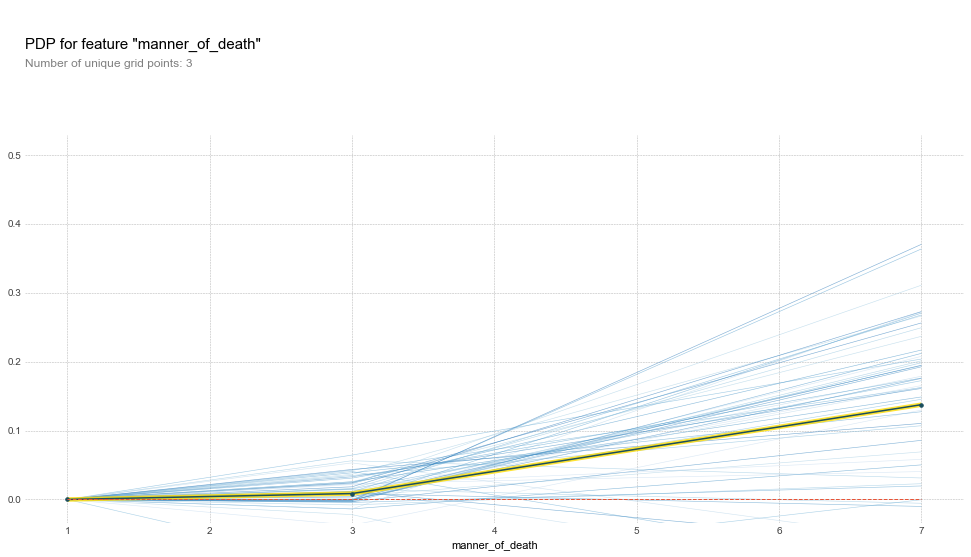

In [36]:
# Let's look at how place of death affects the model
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'manner_of_death'

feat_map, names, codes = feature_mapping(feature)

isolated = pdp_isolate(
    model=model, 
    dataset=X_val_encoded, 
    model_features=X_val_encoded.columns, 
    feature=feature
)

pdp_plot(isolated, feature_name=feature, plot_lines=True, frac_to_plot=50);
# Change the xticks labels
#plt.xticks([1,2,3,4,5,6,7], names);

In [17]:
# Look at marital status compared to education level
from pdpbox.pdp import pdp_interact, pdp_interact_plot

# Define function that takes any 2 features and returns an interactive PDP
def interactive_plot(a, b):
    # Assign inputs as features
    features = [a, b]   
    

    # Build interaction model
    interaction = pdp_interact(
        model=model,
        dataset=X_val_encoded, 
        model_features=X_val_encoded.columns, 
        features=features
    )

    # Create pivot table
    pdp = interaction.pdp.pivot_table(
        values='preds',
        columns=features[0],
        index=features[1]
    )

    # Get names and codes from encoder.mapping
    _, a_names, a_codes = feature_mapping(features[0])
    _, b_names, b_codes = feature_mapping(features[1])

    # Add column & index names to pivot table
    pdp = pdp.rename(index=dict(zip(b_codes, b_names)),
                     columns=dict(zip(a_codes, a_names)))


    # Set plot's figure size
    plt.figure(figsize=(10,8))
    return sns.heatmap(pdp, annot=True, fmt='.2f', cmap='YlGnBu');

In [37]:
# Interactive widget based on top categorical features as determined by permutation importance
# test run earlier
interactive_widget = interactive(
    interactive_plot,
    a=['marital_status', 'education_level', 'place_of_death_and_decedents_status', 'race', 'method_of_disposition', 'manner_of_death'],
    b=['marital_status', 'education_level', 'place_of_death_and_decedents_status', 'race', 'method_of_disposition', 'manner_of_death']
)

display(interactive_widget)

interactive(children=(Dropdown(description='a', options=('marital_status', 'education_level', 'place_of_death_…

In [19]:
# The model looks good!
# How does it do on the test data?
X_test_encoded = encoder.transform(X_test)
test_pred_proba = model.predict_proba(X_test_encoded)[:,1]
roc_auc_score(y_test, test_pred_proba)

0.738322515185678

In [20]:
# Define a function where the user puts in some arguments and the computer
# predicts whether it's a male or female
import shap

def create_dataframe():
    df = pd.DataFrame(
        data=[[X_train['resident_status'].mode()[0], 
              X_train['month_of_death'].mode()[0],
              0,
              X_train['place_of_death_and_decedents_status'].mode()[0], 
              0,
              X_train['injury_at_work'].mode()[0],
              X_train['manner_of_death'].mode()[0], 
              X_train['method_of_disposition'].mode()[0],
              X_train['autopsy'].mode()[0],
              X_train['activity_code'].mode()[0],
              0,
              X_train['hispanic_origin'].mode()[0],
              0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
        columns=['resident_status', 'month_of_death', 'detail_age', 'place_of_death_and_decedents_status', 
                 'marital_status', 'injury_at_work', 'manner_of_death', 'method_of_disposition', 'autopsy', 
                 'activity_code', 'race', 'hispanic_origin', 'education_level', 'heart_disease', 'cancer', 
                 'hiv', 'suicide', 'homicide', 'accident', 'alzheimers', 'respiratory', 'diabetes']
    )
    
    return df


def predict(age, marital_status, education_level, race, cause_of_death):
    
    # Create dataframe
    df = create_dataframe()
    
    # Store input data in dataframe
    df['detail_age'] = age
    df['marital_status'] = marital_status
    df['education_level'] = education_level
    df['race'] = race
    
    # Assign 1 to column for cause_of_death, else 0
    if cause_of_death in df.columns:
        df[cause_of_death] = 1
    
    # Encode the dataframe
    X_encoded = encoder.transform(df)
    
    
    # Assign positive class and index number
    positive_class = 'Male'
    positive_class_index = 1 
    
    # Call model for prediction
    pred = model.predict(X_encoded)
    predict = pred[0]
    
    # Get predicted probability
    pred_proba = model.predict_proba(X_encoded)[0,positive_class_index]
    
    probability = pred_proba * 100
    if pred != positive_class:
        probability = 100 - probability
    
    # Show prediction and probability
    result = f'Gender is {probability:.0f}% likely to be {predict}\n'
    print(result)

In [21]:
new_widget = interactive(predict, 
         age=(0,150,1), 
         marital_status=['Married', 'Divorced', 'Widowed', 'Never married, single', 'Marital status unknown'],
         education_level=['8th grade or less', 'high school', 'college', 'graduate', 'postgraduate', 'unknown'],
         race=['White', 'Black', 'Other Asian or Pacific Islander in areas reporting codes 18-58', 
               'Vietnamese', 'American Indian (includes Aleuts and Eskimos)', 'Filipino', 'Chinese', 
               'Japanese', 'Combined other Asian or Pacific Islander, includes codes 18-68', 'Asian Indian', 
               'Korean', 'Samoan', 'Guamanian', 'Hawaiian (includes Part-Hawaiian)'],
         cause_of_death=['heart_disease', 'cancer', 'hiv', 'suicide', 'homicide', 'accident', 
                         'alzheimers', 'respiratory', 'diabetes', 'none'],
)

display(new_widget)

interactive(children=(IntSlider(value=75, description='age', max=150), Dropdown(description='marital_status', …

In [22]:
# Define explainer function to show shapley values for our test data
def explainer(row_number):
    
    positive_class = 'Male'
    positive_class_index = 1
    
    # Get & process the data for the row
    row = X_test.loc[[row_number]]
    row_processed = encoder.transform(row)
    
     # Call model for prediction
    pred = model.predict(row_processed)
    predict = pred[0]
    
    # Get predicted probability
    pred_proba = model.predict_proba(row_processed)[0,positive_class_index]
    probability = pred_proba * 100
    if pred != positive_class:
        probability = 100 - probability
    
    # Show prediction and probability
    result = f'Gender is {probability:.0f}% likely to be {predict}\n'
    print(result)
    
    # Get SHAP values
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(row_processed)
    
    shap.initjs()
    return shap.force_plot(
        base_value=explainer.expected_value,
        shap_values=shap_values,
        features=row
    )

In [23]:
# Compare our test y vector with our test predicted probabilities
df = pd.DataFrame({
    'true': y_test,
    'predicted': test_pred_proba
                  }
)

male = y_test == 'Male'
female = ~male
right = (male) == (df['predicted'] > 0.50)
wrong = ~right


df[male & right].sample(n=10, random_state=1).sort_values(by='predicted')

,true,predicted
227365,Male,0.535109
698912,Male,0.540199
157399,Male,0.634292
675528,Male,0.652121
278443,Male,0.686364
123068,Male,0.701394
411635,Male,0.719790
494627,Male,0.732138
9816,Male,0.766434
170699,Male,0.780465


In [25]:
explainer(227365)

Gender is 54% likely to be Male



In [26]:
df[male & wrong].sample(n=10, random_state=1).sort_values(by='predicted')

,true,predicted
89542,Male,0.201683
586800,Male,0.219423
274588,Male,0.267173
471131,Male,0.268301
499458,Male,0.283150
456586,Male,0.288770
310738,Male,0.293207
616872,Male,0.399919
183421,Male,0.408512
309813,Male,0.427997


In [27]:
explainer(309813)

Gender is 57% likely to be Female



In [28]:
df[female & right].sample(n=10, random_state=1).sort_values(by='predicted')

,true,predicted
111963,Female,0.160074
205556,Female,0.183542
355995,Female,0.190531
648260,Female,0.207280
345468,Female,0.263549
488636,Female,0.312860
370861,Female,0.331751
316335,Female,0.339934
59829,Female,0.364051
43509,Female,0.384746


In [29]:
explainer(43509)

Gender is 62% likely to be Female



In [38]:
df[female & wrong].sample(n=10, random_state=1).sort_values(by='predicted')

,true,predicted
169567,Female,0.539862
327125,Female,0.546748
27424,Female,0.619734
634816,Female,0.623524
77989,Female,0.648880
285266,Female,0.668630
578934,Female,0.670901
308402,Female,0.671456
488634,Female,0.690968
47099,Female,0.910587


In [39]:
explainer(47099)

Gender is 91% likely to be Male

